# Collect metrics from a log directory, result contains epochs corresponding to the best models in each KLD group

In [6]:
import pandas as pd
from utils_analysis.helpers import collect_metrics

pd.set_option('display.max_columns', 500)
PATH = "logs/H4H-bvae-cond"

df = collect_metrics(PATH)

kld_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
kld_labels = [i for i in range(len(kld_bins)-1)]

df['kld_group'] = pd.cut(df['loss_kld'], bins=kld_bins, labels=kld_labels).astype(float)
result = df.loc[
    df.groupby(["version","kld_group"])[['loss_rec']].idxmin().stack()
]

# Get Pareto Front: All these models are optimal in a sense that no other model is better with respect to both: kld loss and rec loss
`pip install paretoset`

In [7]:
from paretoset import paretoset

mask = paretoset(result[["loss_kld", "loss_rec"]], sense=["min", "min"])
df_pareto = result[mask]
df_pareto.sort_values("loss_kld")

,beta,epoch,loss_kld,loss_rec,saved,step,train_loss,version,L,activation,baseline,batch_size,cyclical,cyclical_annealing,encoding,latent_dim,loss,lr,mode,num_epochs,num_workers,optimizer,rec_weight,shape,total_steps,kld_group
0,1.388794e-11,0,0.148739,0.912990,1.0,38,9.129901,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,1.0
477,8.807973e-01,477,0.294771,0.011013,1.0,18641,0.369767,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,2.0
475,5.000000e-01,475,0.348372,0.007754,1.0,18563,0.251729,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,3.0
474,2.689414e-01,474,0.408297,0.005795,1.0,18524,0.167755,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,4.0
473,1.192029e-01,473,0.551664,0.004153,1.0,18485,0.107291,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,5.0
322,4.742586e-02,322,0.792615,0.003980,1.0,12596,0.077390,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,7.0
472,4.742586e-02,472,0.825364,0.003270,1.0,18446,0.071843,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,8.0


In [8]:
import matplotlib.pyplot as plt

def create_scatter_plot(df, x_col, y_col, version_col="version"):
    fig, ax = plt.subplots(figsize=(8, 6))
    categories = df[version_col].astype('category')
    scatter = ax.scatter(df[x_col], df[y_col], c=categories.cat.codes, cmap='viridis', alpha=0.7, edgecolor='k')
    legend_labels = categories.cat.categories
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
                      for i in range(len(legend_labels))]
    ax.legend(legend_handles, legend_labels, title=version_col)
    ax.set_title("Pareto Front")
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    return fig


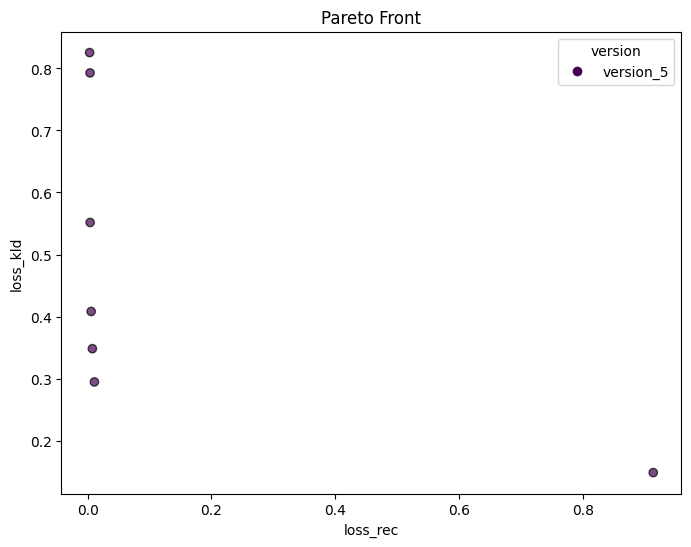

In [9]:
fig = create_scatter_plot(df_pareto, x_col='loss_rec', y_col='loss_kld')

# Model Analysis

In [13]:
import torch
import numpy as np

from utils_analysis.helpers import load_data_and_model
from utils_analysis.plotting_functions import plot_dfp_real_vs_sim
from utils_analysis.data_generation_functions import cond_vae_generate_data_from_prior
from sklearn.preprocessing import StandardScaler

from tools import Evaluator_FTIR, Standard_Analysis

Overview of our best models

In [18]:
df_pareto.sort_values("loss_kld").head(20)

,beta,epoch,loss_kld,loss_rec,saved,step,train_loss,version,L,activation,baseline,batch_size,cyclical,cyclical_annealing,encoding,latent_dim,loss,lr,mode,num_epochs,num_workers,optimizer,rec_weight,shape,total_steps,kld_group
0,1.388794e-11,0,0.148739,0.912990,1.0,38,9.129901,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,1.0
477,8.807973e-01,477,0.294771,0.011013,1.0,18641,0.369767,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,2.0
475,5.000000e-01,475,0.348372,0.007754,1.0,18563,0.251729,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,3.0
474,2.689414e-01,474,0.408297,0.005795,1.0,18524,0.167755,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,4.0
473,1.192029e-01,473,0.551664,0.004153,1.0,18485,0.107291,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,5.0
322,4.742586e-02,322,0.792615,0.003980,1.0,12596,0.077390,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,7.0
472,4.742586e-02,472,0.825364,0.003270,1.0,18446,0.071843,version_5,3,elu,0,524,True,True,True,100,bvae,0.0001,cond,500,8,Adam,10,logistic,50,8.0


Choose a version from the dataframe and the kld range

In [15]:
version = 5
kld = "2_3"

prepare the data and model 

In [16]:
#def load_model_and_create_data(version, kld, path = PATH):
VERSION = f"/version_{version}/"
FOLDER = f"res_v_{version}_" + kld
EPOCH_NAME = f"v_{version}-{kld}"

dm, model = load_data_and_model(path = PATH + VERSION, model_name="model_kld_" + kld + ".pth")
df_real = dm.dataset.df_test_scaled.iloc[:,:519]
df_labels = dm.dataset.df_test_scaled[["age", "sex", "bmi"]]
column_names = df_real.columns.astype("float").values
split_index = dm.dataset.df_test_scaled["test_set"].values

# generate condvae
df_sim_scaled = cond_vae_generate_data_from_prior(model.float(), df_labels[["age", "sex", "bmi"]], normalize_generated_data=False)
gen_data = df_sim_scaled.iloc[:,:519]

#df_sim_scaled[["age", "bmi"]] = dm.dataset.min_max_scaler.inverse_transform(df_sim_scaled[["age", "bmi"]])
#df_sim_scaled.to_parquet("df_vae_encoding.parquet")

df_labels.loc[:,["age", "bmi"]] = dm.dataset.min_max_scaler.inverse_transform(df_labels[["age", "bmi"]])

age_threshold = 50
bmi_threshold = 27
df_labels.loc[df_labels.age <= age_threshold, "age"] = 0
df_labels.loc[df_labels.bmi <= bmi_threshold, "bmi"] = 0
df_labels.loc[df_labels.age > age_threshold, "age"] = 1
df_labels.loc[df_labels.bmi > bmi_threshold, "bmi"] = 1

real_data_scaled = df_real.values #scaler.fit_transform(df_real.values)
gen_data_scaled = gen_data.values #scaler.transform(gen_data.values)

spectra_map = {"VAE": gen_data_scaled,
              # "GAN": gan_data,
               "real": real_data_scaled}

label_map = {"VAE": df_labels.values,
             #"GAN": labels,
             "real": df_labels.values}

split_index_map = {"VAE": split_index,
                  #"GAN": labels,
                   "real": split_index}

label_names = ["age", "sex", "bmi"]

vec = column_names

scaler = dm.dataset.standard_scaler

Loaded hyperparameters: {'L': 3, 'activation': 'elu', 'baseline': 0, 'batch_size': 524, 'cyclical': True, 'cyclical_annealing': True, 'encoding': True, 'latent_dim': 100, 'loss': 'bvae', 'lr': 0.0001, 'mode': 'cond', 'num_epochs': 500, 'num_workers': 8, 'optimizer': 'Adam', 'rec_weight': 10, 'shape': 'logistic', 'total_steps': 50}


# Perform Standard Analysis

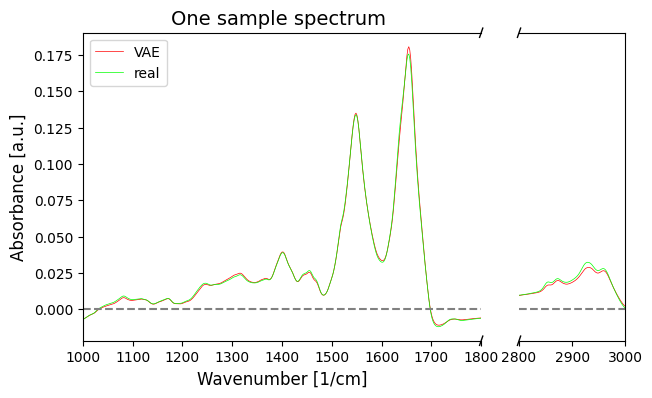

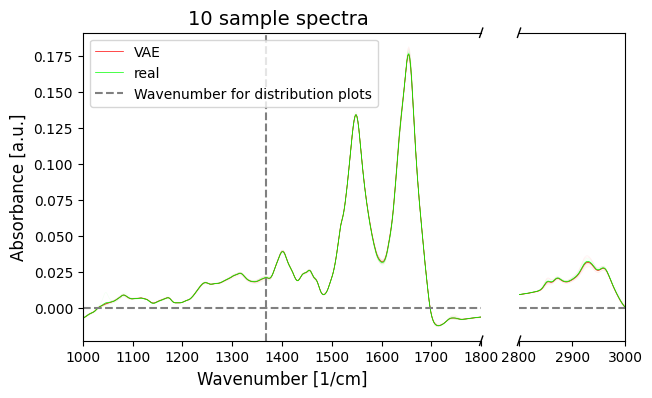

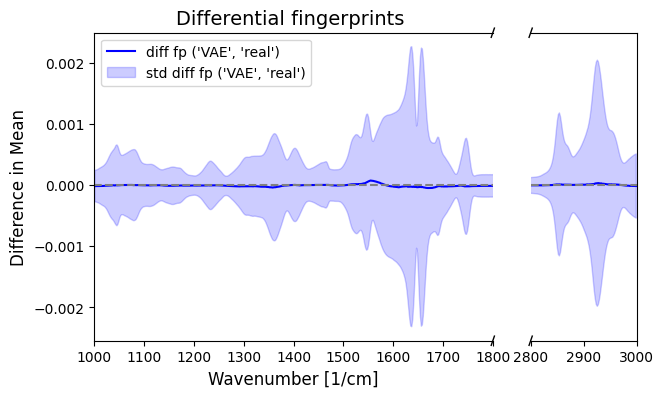

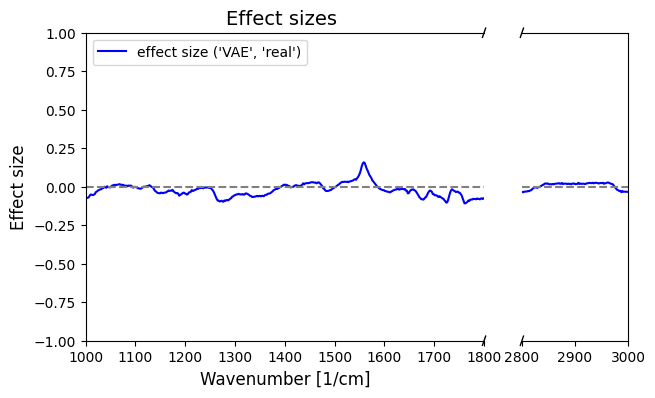

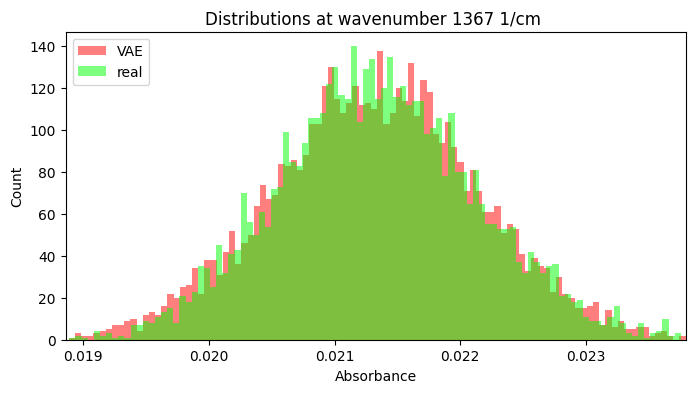

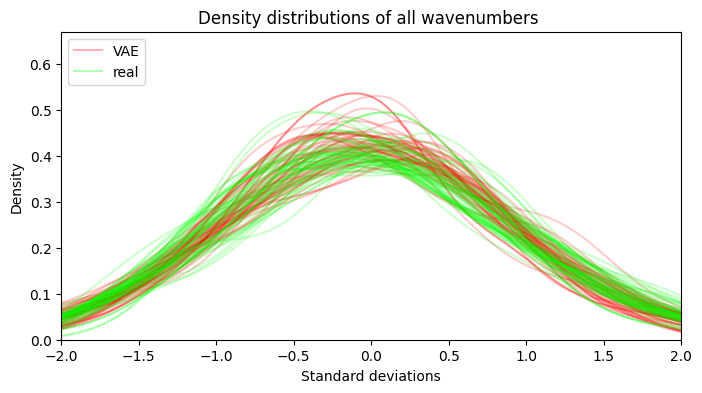

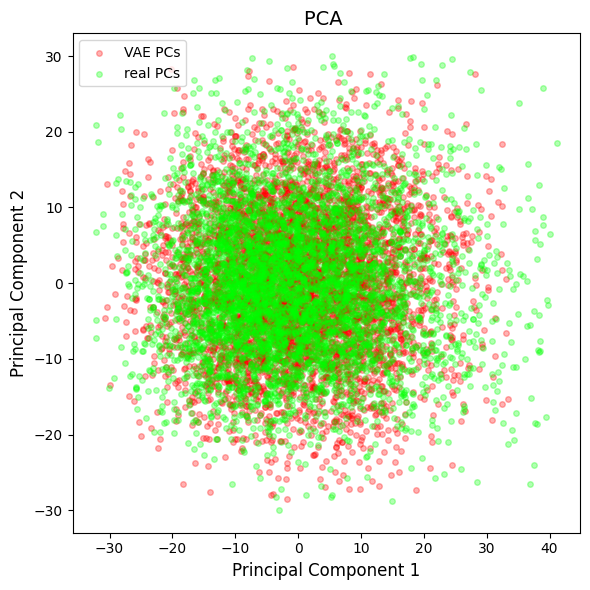

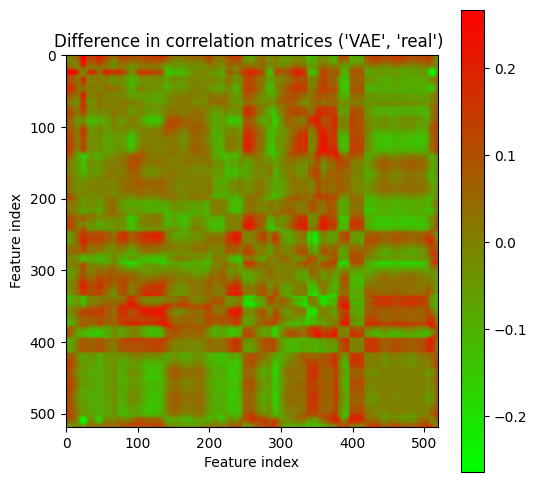

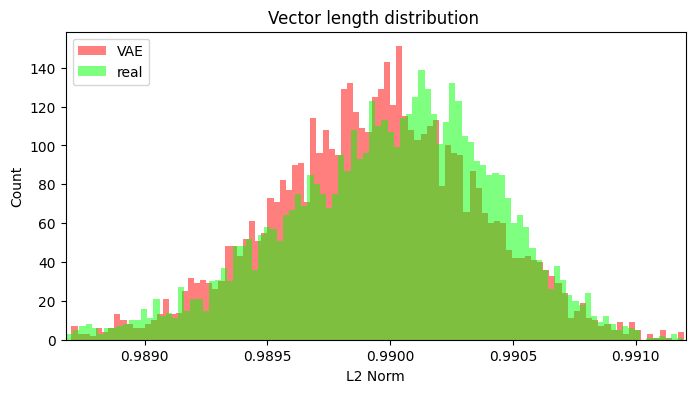

/raven/u/thalenke/projects/ag-kepesidis/vae/tools/Evaluator.py:564: RuntimeWarning: divide by zero encountered in log
  p_value = np.nan_to_num(np.log(hotelling_results[2]), nan=-256)


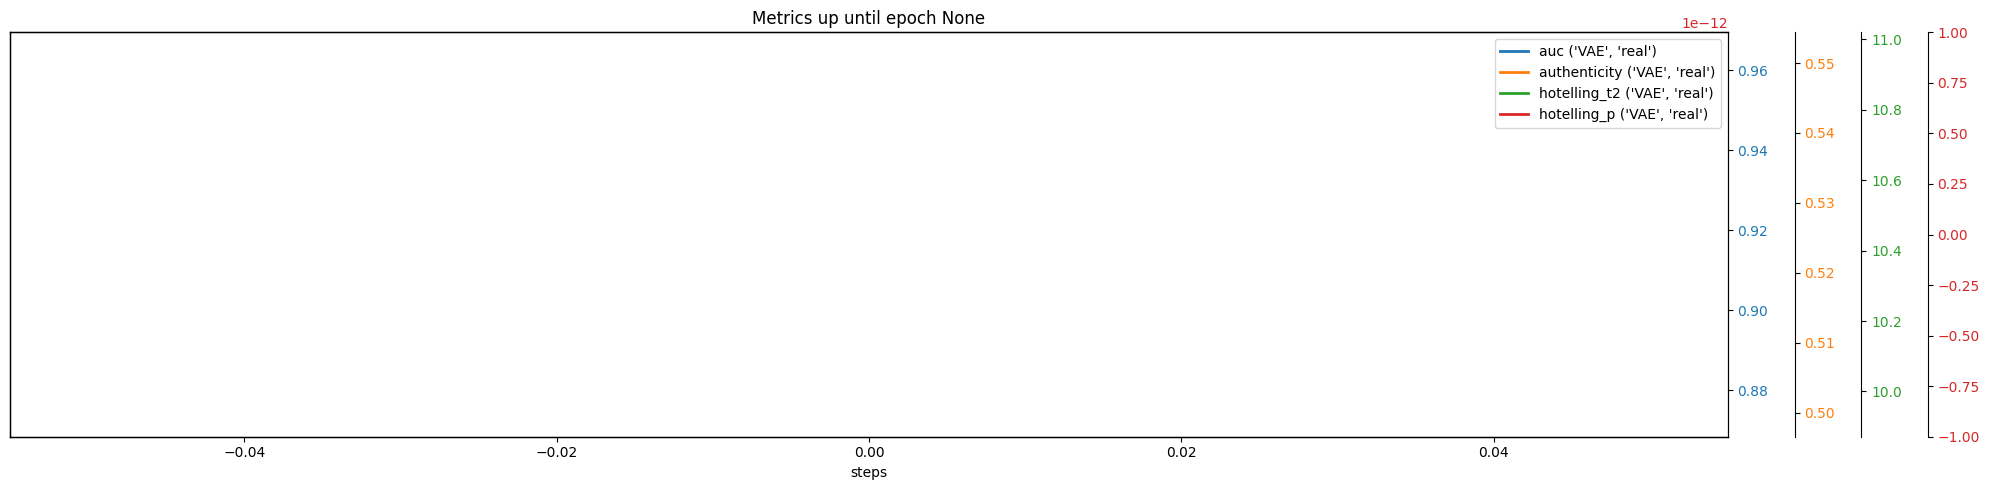

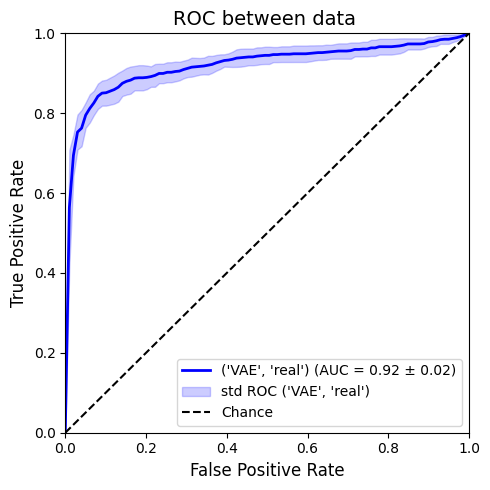

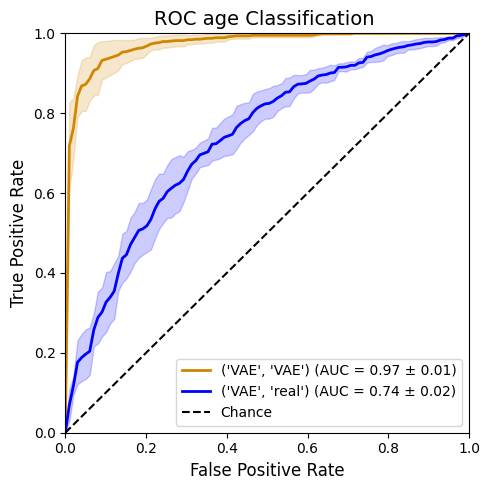

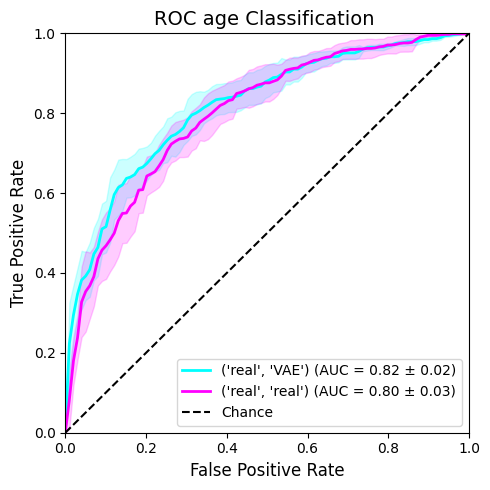

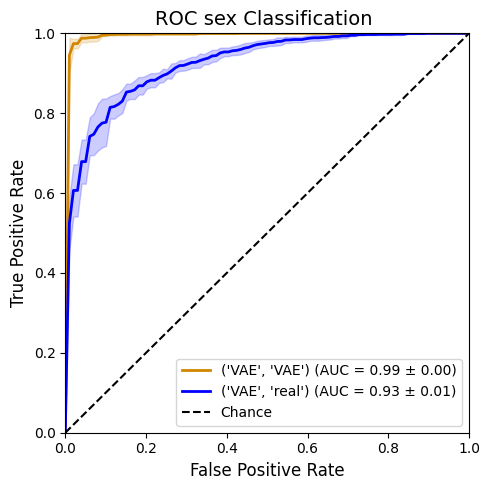

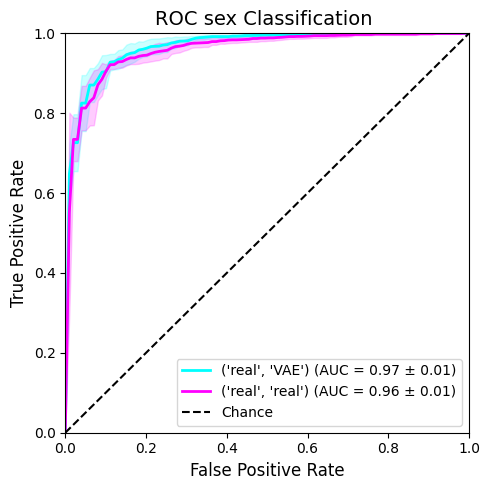

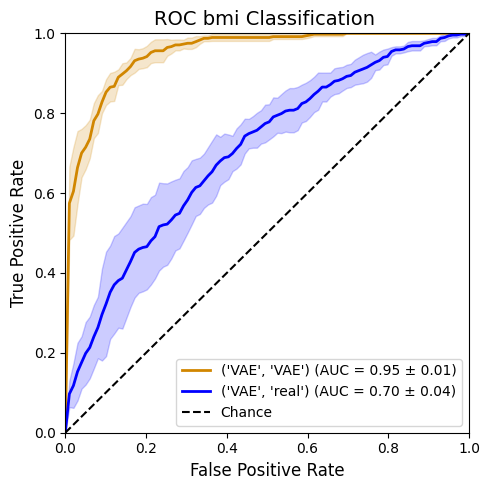

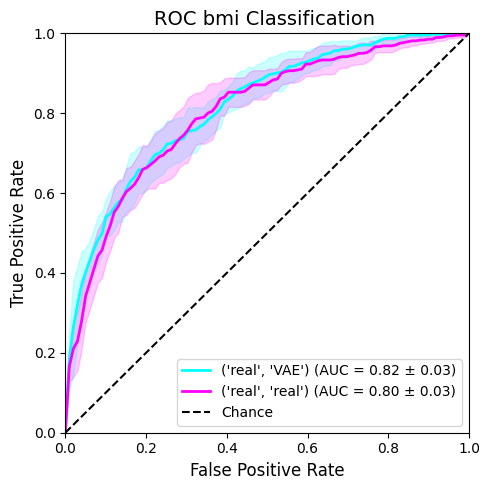

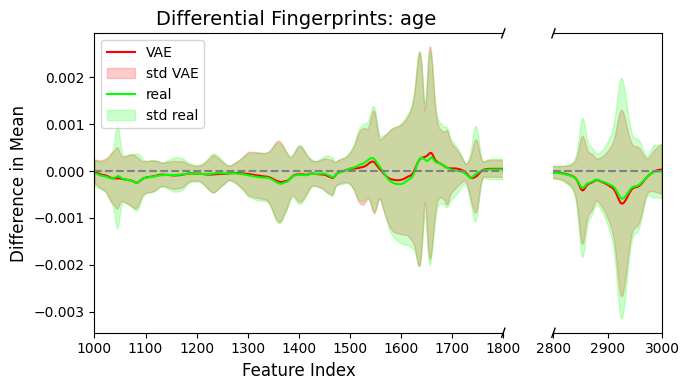

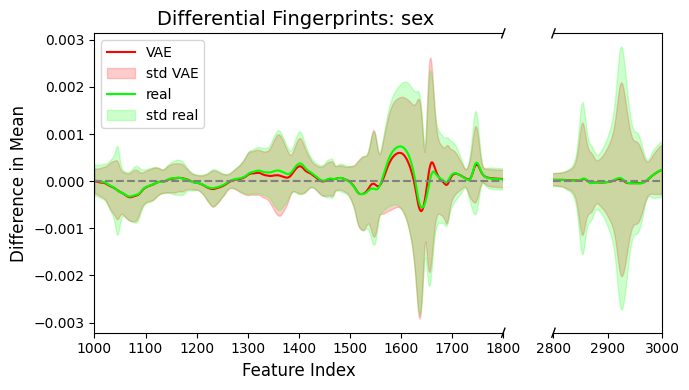

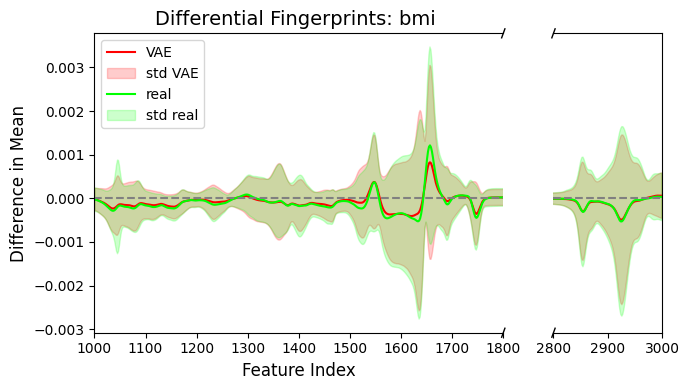

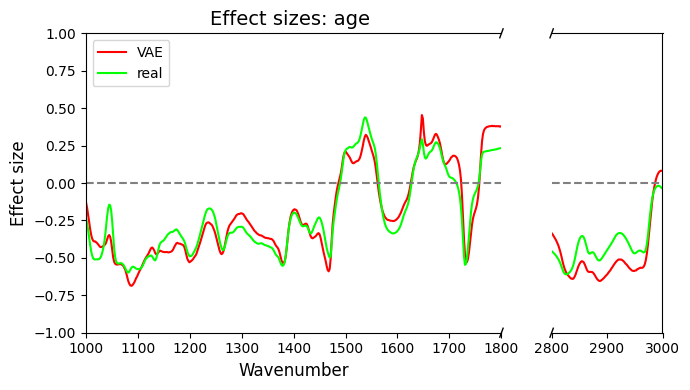

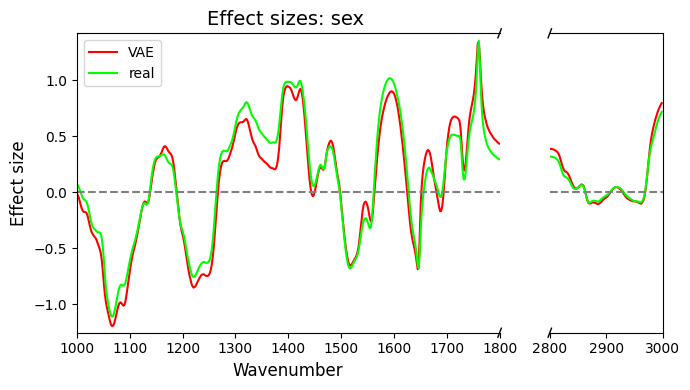

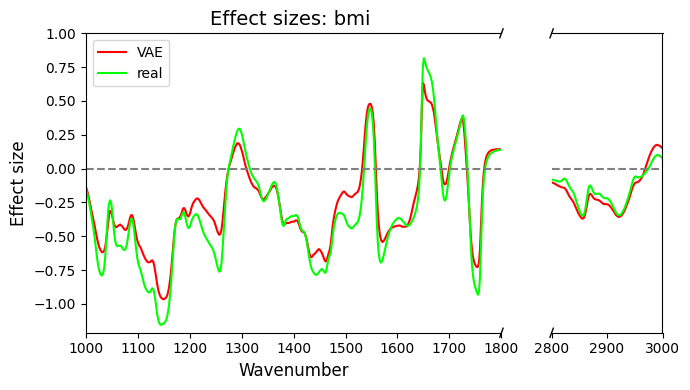

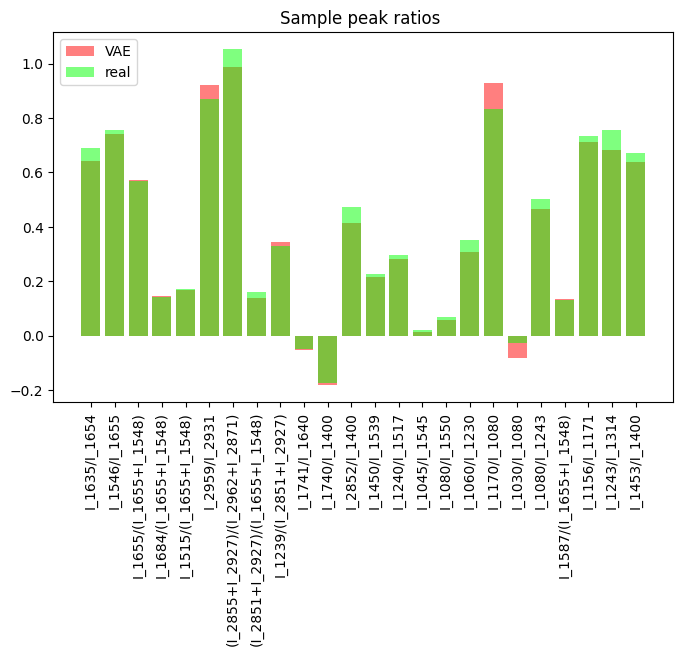

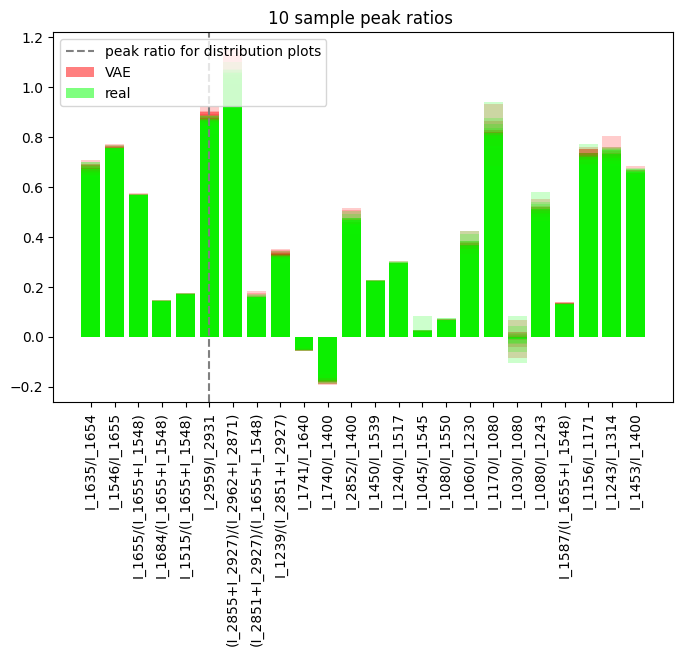

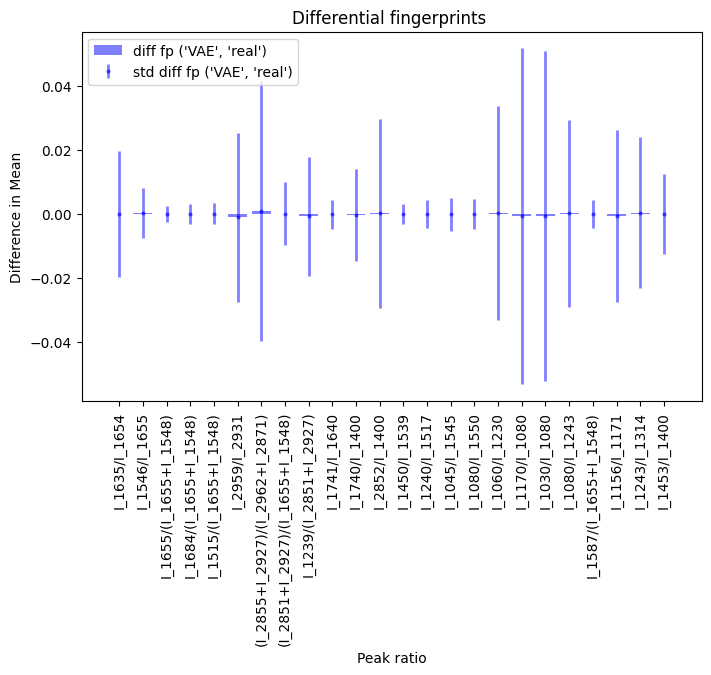

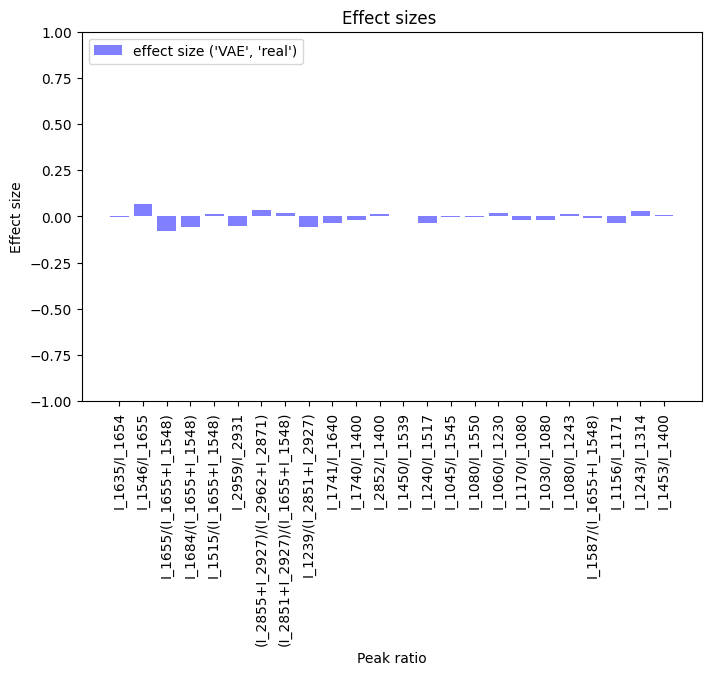

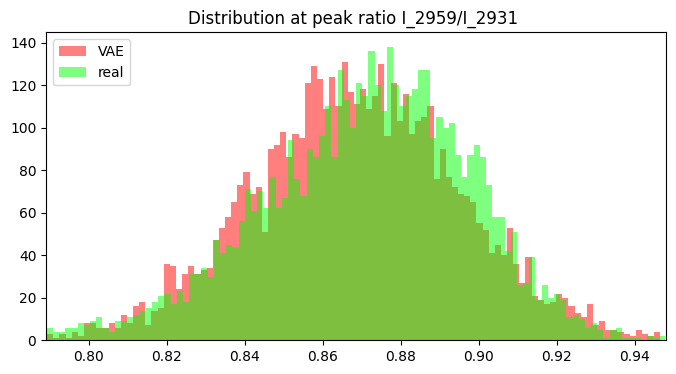

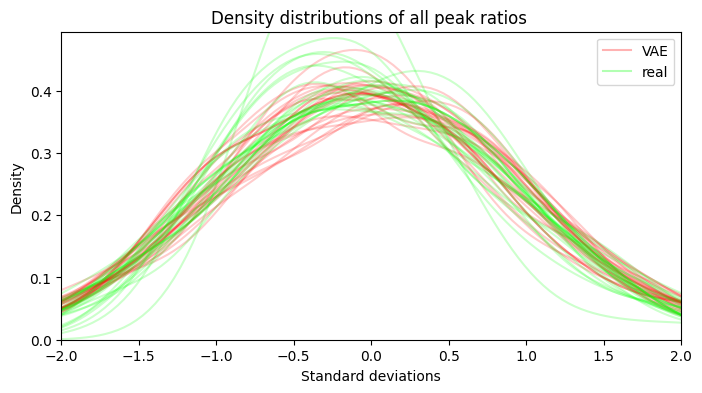

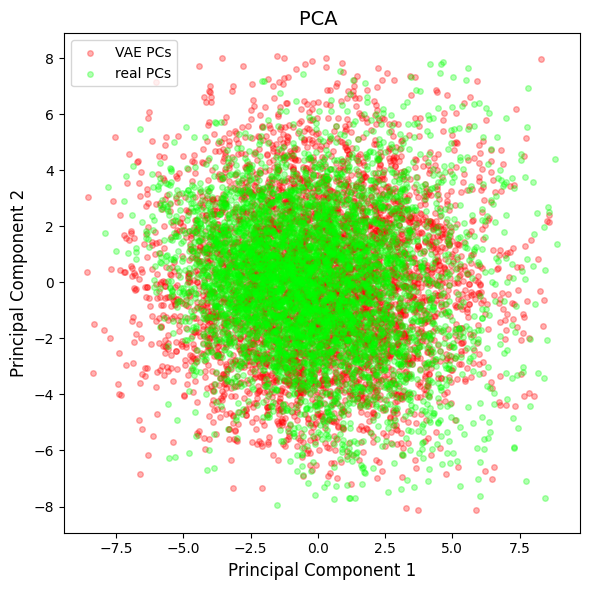

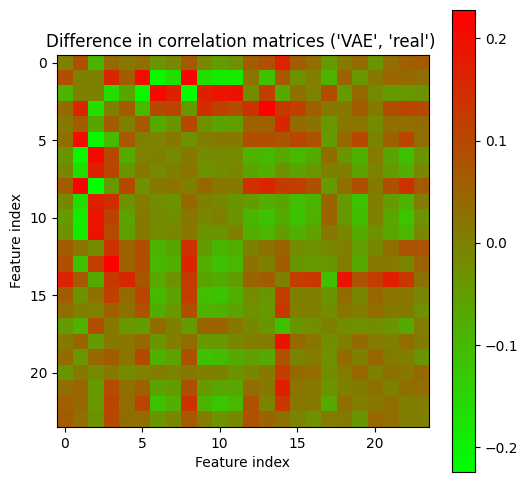

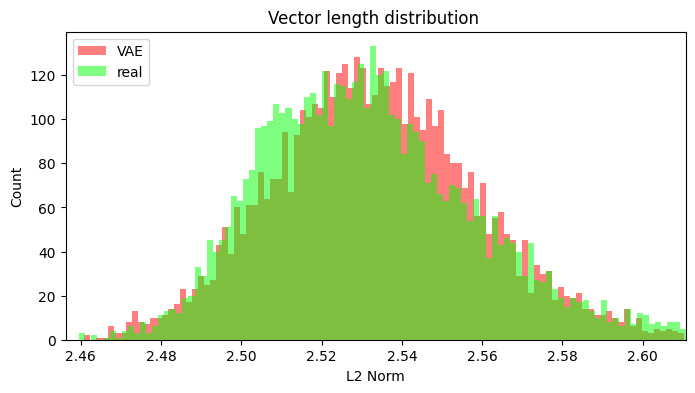

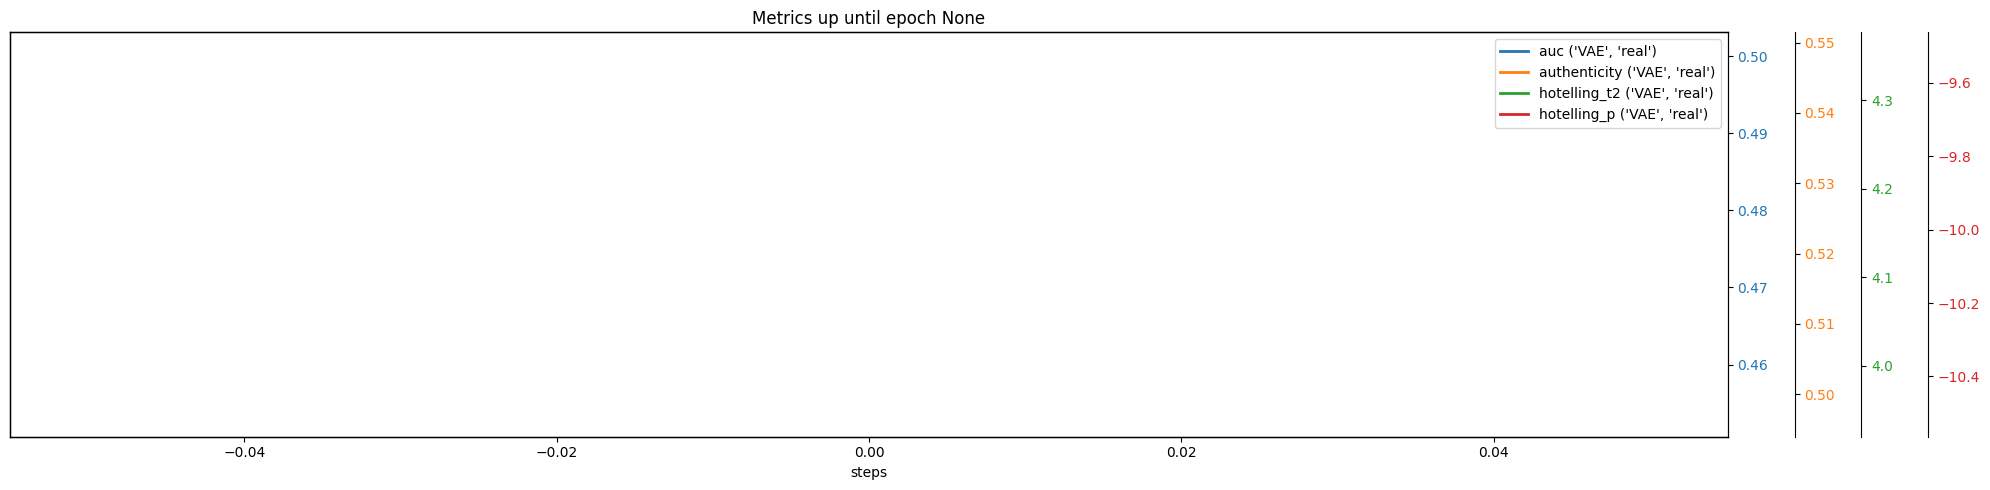

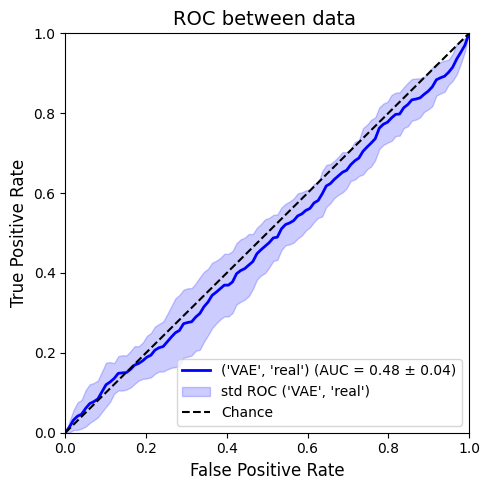

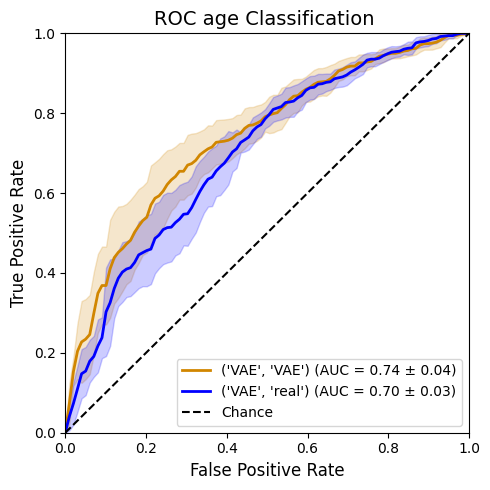

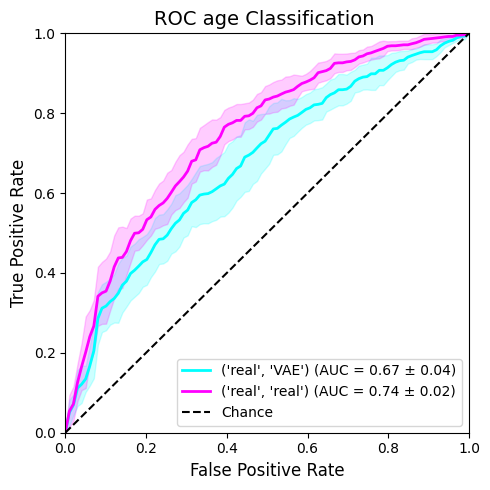

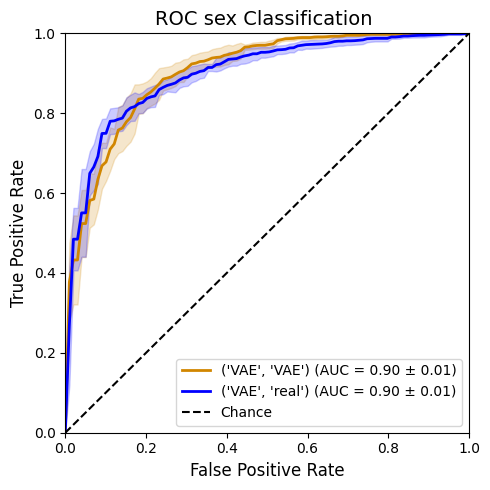

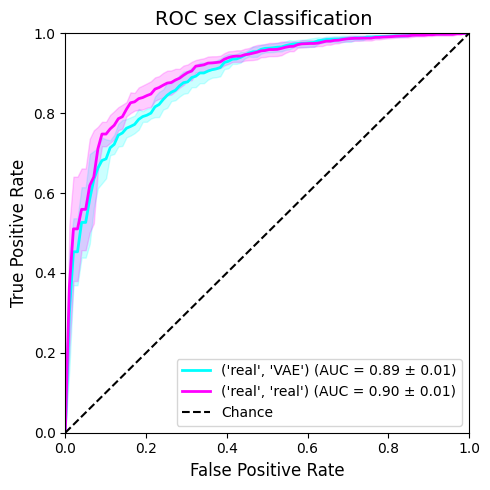

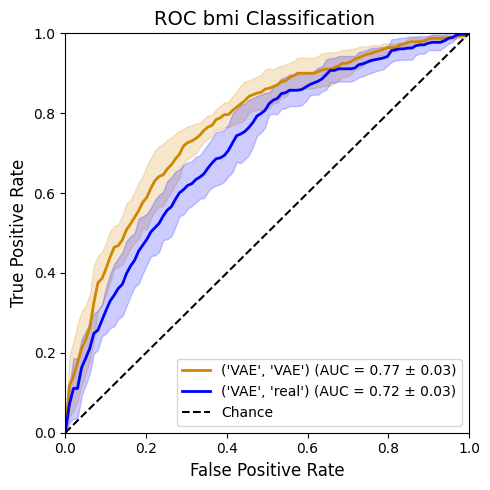

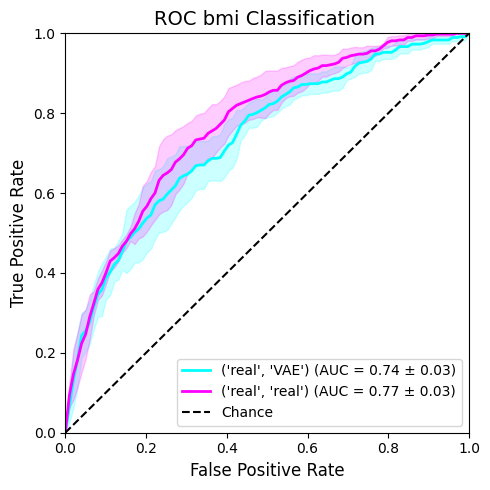

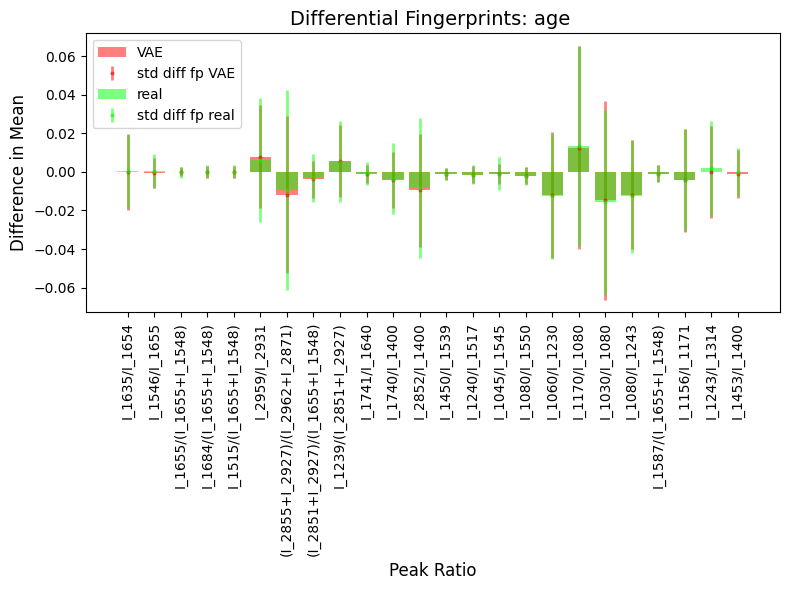

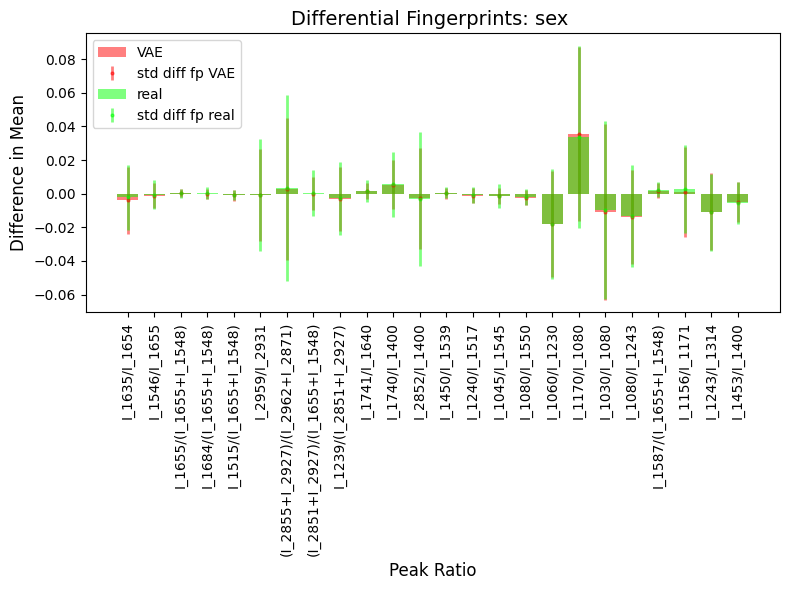

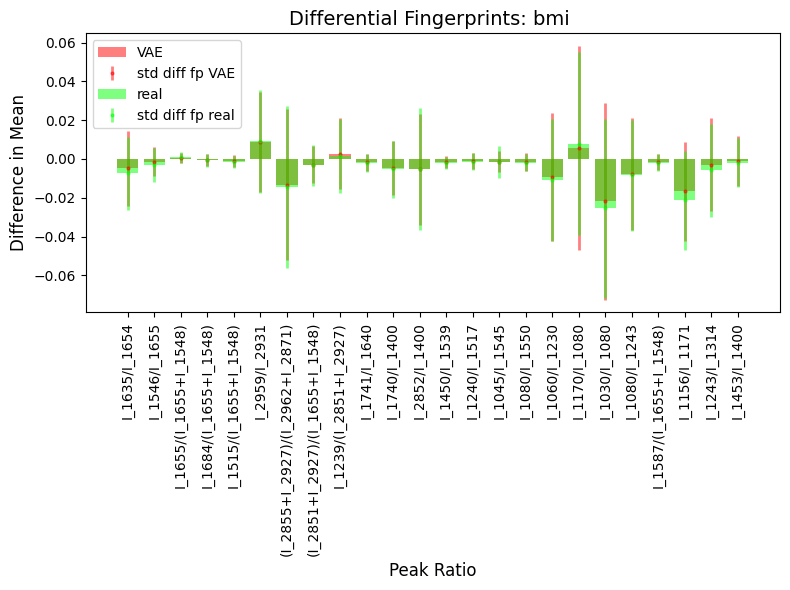

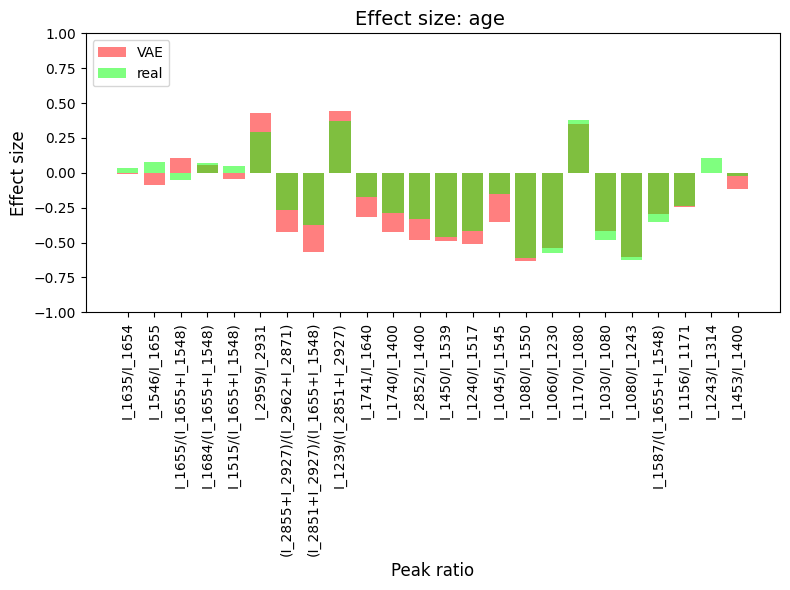

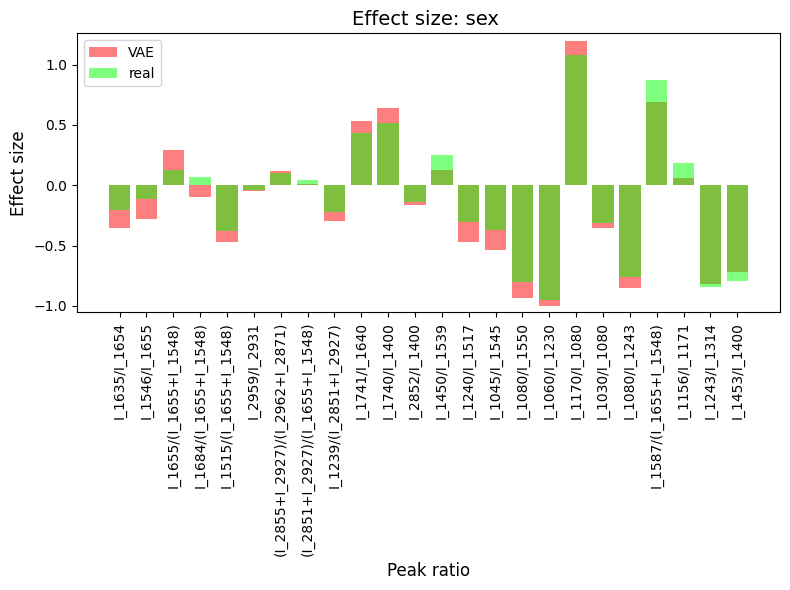

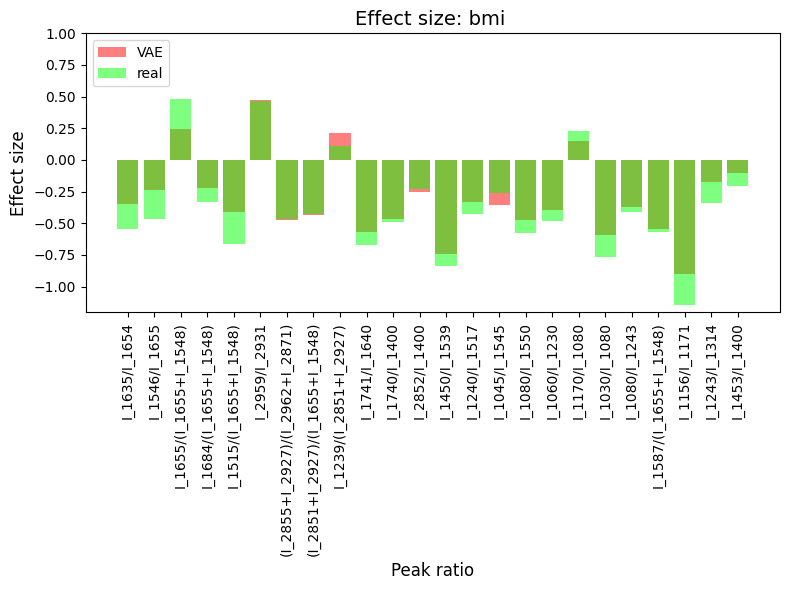

In [36]:
Standard_Analysis.Standard_Analysis(spectra_map,
                                    label_map,
                                    label_names,
                                    scaler,
                                    split_index_map,
                                    vec = column_names)

# Rename the created plots

In [5]:
import os

# Define the mapping for renaming files
conditional_analysis_mapping = {
    "1": "ROC_age_trained_on_vae",
    "2": "ROC_age_trained_on_real",
    "3": "ROC_sex_trained_on_vae",
    "4": "ROC_sex_trained_on_real",
    "5": "ROC_bmi_trained_on_vae",
    "6": "ROC_bmi_trained_on_real",
    "7": "DFP_age",
    "8": "DFP_sex",
    "9": "DFP_bmi",
    "10": "Effect_size_age",
    "11": "Effect_size_sex",
    "12": "Effect_size_bmi"
}

distribution_analysis_mapping = {
    "1": "1_Sample",
    "2": "10_Samples",
    "3": "DFP",
    "4": "Effect_size",
    "5": "Distribution_at",
    "6": "KDE_Distributions",
    "7": "PCA",
    "8": "Difference_Correlation_Matrix",
    "9": "Vector_length"
}

def rename_plots(base_folder = ""):
    for folder in ["Spectra", "PeakRatios"]:
        for subfolder in ["Conditional_Analysis", "Distribution_Analysis"]:
            folder_path = os.path.join(base_folder, folder, subfolder)
            if not os.path.exists(folder_path):
                print(f"Skipping missing directory: {folder_path}")
                continue
            
            mapping = conditional_analysis_mapping if subfolder == "Conditional_Analysis" else distribution_analysis_mapping
            
            for filename in os.listdir(folder_path):
                if filename.endswith(".png"):
                    parts = filename.split("_Plot_")
                    if len(parts) == 2:
                        number_part = parts[1].split(".")[0]  # Extract the number
                        if number_part in mapping:
                            new_name = f"{folder}_{mapping[number_part]}.png"
                            old_path = os.path.join(folder_path, filename)
                            new_path = os.path.join(folder_path, new_name)
                            os.rename(old_path, new_path)
                            print(f"Renamed: {old_path} -> {new_path}")
                        else:
                            print(f"Skipping file with unknown number: {filename}")
                            
rename_plots("plots/")

Renamed: plots/Spectra/Distribution_Analysis/_Plot_7.png -> plots/Spectra/Distribution_Analysis/Spectra_PCA.png
Renamed: plots/Spectra/Distribution_Analysis/_Plot_9.png -> plots/Spectra/Distribution_Analysis/Spectra_Vector_length.png
Renamed: plots/Spectra/Distribution_Analysis/_Plot_4.png -> plots/Spectra/Distribution_Analysis/Spectra_Effect_size.png
Renamed: plots/Spectra/Distribution_Analysis/_Plot_1.png -> plots/Spectra/Distribution_Analysis/Spectra_1_Sample.png
Renamed: plots/Spectra/Distribution_Analysis/_Plot_6.png -> plots/Spectra/Distribution_Analysis/Spectra_KDE_Distributions.png
Renamed: plots/Spectra/Distribution_Analysis/_Plot_8.png -> plots/Spectra/Distribution_Analysis/Spectra_Difference_Correlation_Matrix.png
Renamed: plots/Spectra/Distribution_Analysis/_Plot_3.png -> plots/Spectra/Distribution_Analysis/Spectra_DFP.png
Renamed: plots/Spectra/Distribution_Analysis/_Plot_2.png -> plots/Spectra/Distribution_Analysis/Spectra_10_Samples.png
Renamed: plots/Spectra/Distributio